#Carga de datos

In [0]:
dfPopulation = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/poblacion.csv")

dfPoverty = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/pobreza.csv")

dfArrests = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/arrestos.csv")

dfCrashes = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/colisiones.csv")

df5 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/2016___2017_Health_Education_Report.csv")


#Exploración de los datos

Porcentaje de arrestos según población total por localidad

In [0]:
from pyspark.sql.functions import split,when
import pandas as pd



dfArrests = dfArrests.withColumn("ARREST_BORO",when(dfArrests["ARREST_BORO"] == "K", "Brooklyn").when(dfArrests["ARREST_BORO"] == "B", "Bronx").when(dfArrests["ARREST_BORO"] == "M", "Manhattan").when(dfArrests["ARREST_BORO"] == "Q", "Queens").when(dfArrests["ARREST_BORO"] == "S", "Staten Island").otherwise(dfArrests["ARREST_BORO"]))



dfPopulation2022 = dfPopulation[["Borough","2020","2020 - Boro share of NYC total"]].withColumnRenamed("2020","year2020")
dfPopulation2022 = spark.createDataFrame(dfPopulation2022.tail(dfPopulation2022.count()-1), dfPopulation2022.schema).sort("Borough")
dfPopulation2022 = dfPopulation2022.withColumnRenamed("Borough","ARREST_BORO")

#display(dfPopulation2022)

dfArrestsDate = dfArrests.withColumn('month', split(dfArrests['ARREST_DATE'], '/').getItem(0)) \
       .withColumn('day', split(dfArrests['ARREST_DATE'], '/').getItem(1)) \
       .withColumn('year', split(dfArrests['ARREST_DATE'], '/').getItem(2))

#display(dfArrestsDate)
por_year = dfArrestsDate.groupBy("year").count()
por_boro = dfArrestsDate.groupBy("ARREST_BORO").count().sort("ARREST_BORO")
por_boro = por_boro.withColumnRenamed("count","cantidad")
#display(por_boro)
por_borodf=por_boro.toPandas()
population2022Df= dfPopulation2022.toPandas()

#join=dfPopulation2022.join(por_boro,"ARREST_BORO").select("ARREST_BORO",  (por_boro.cantidad / dfPopulation2022["2020 - Boro share of NYC total"]).alias("product"))

por_borodf["Porcentaje según población total"]= (por_borodf["cantidad"]*100)/population2022Df["year2020"]

percentajePerBorough = spark.createDataFrame(por_borodf) 
display(percentajePerBorough.withColumnRenamed("ARREST_BORO","Arrestos"))


Arrestos,cantidad,Porcentaje según población total
Bronx,21198,1.4651766533866746
Brooklyn,25431,0.960221291531808
Manhattan,22997,1.4037274435826332
Queens,19416,0.83319923014039
Staten Island,4196,0.8613275035666267


Cantidad de arrestos según edad y sexo

In [0]:
dfPeople = dfArrests.groupBy("AGE_GROUP","PERP_SEX").count().sort("AGE_GROUP").withColumnRenamed("PERP_SEX","Género").withColumnRenamed("AGE_GROUP","Rango de edades").withColumnRenamed("count","Cantidad")

display(dfPeople)


Rango de edades,Género,Cantidad
18-24,F,3054
18-24,M,13201
25-44,M,44094
25-44,F,9664
45-64,M,15795
45-64,F,2696
65+,F,212
65+,M,1138
<18,F,643
<18,M,2741


Cantidad de arrestos según raza y sexo

In [0]:
dfPeople2 = dfArrests.groupBy("PERP_RACE","PERP_SEX").count().sort("PERP_RACE").withColumnRenamed("PERP_RACE","Raza").withColumnRenamed("count","Cantidad").withColumnRenamed("PERP_SEX","Género")
display(dfPeople2)

Raza,Género,Cantidad
AMERICAN INDIAN/ALASKAN NATIVE,M,207
AMERICAN INDIAN/ALASKAN NATIVE,F,32
ASIAN / PACIFIC ISLANDER,M,4232
ASIAN / PACIFIC ISLANDER,F,774
BLACK,M,37854
BLACK,F,8260
BLACK HISPANIC,M,7002
BLACK HISPANIC,F,1204
UNKNOWN,M,291
UNKNOWN,F,40


Cantidad de accidentes según tipo de vehículo

In [0]:
from pyspark.sql.functions import split,when,col




porTipoVehículo = dfCrashes.groupBy("VEHICLE_TYPE").count().sort(col("count").desc())
#display(porTipoVehículo.schema)
porTipoVehículo=porTipoVehículo.withColumn("VEHICLE_TYPE",when(col("VEHICLE_TYPE").isNull(), "Sin información").otherwise(porTipoVehículo["VEHICLE_TYPE"])).withColumnRenamed("count","Cantidad").withColumnRenamed("VEHICLE_TYPE","TipoDeVehículo")
porTipoVehículo=porTipoVehículo.head(10)
display(porTipoVehículo)


TipoDeVehículo,Cantidad
PASSENGER VEHICLE,770756
Sedan,653589
Station Wagon/Sport Utility Vehicle,532612
SPORT UTILITY / STATION WAGON,337927
Sin información,120557
UNKNOWN,105357
4 dr sedan,72852
Taxi,69713
TAXI,60785
VAN,49720


Cantidad de accidentes según licencia del conductor

In [0]:
porLicencia = dfCrashes.groupBy("DRIVER_LICENSE_STATUS").count()

porLicencia=porLicencia.withColumn("DRIVER_LICENSE_STATUS",when(col("DRIVER_LICENSE_STATUS").isNull(), "Sin información").otherwise(porLicencia["DRIVER_LICENSE_STATUS"])).withColumnRenamed("DRIVER_LICENSE_STATUS","EstadoDeLaLicenciaDelConductor").withColumnRenamed("count","Cantidad")
display(porLicencia)

EstadoDeLaLicenciaDelConductor,Cantidad
Sin información,1935085
Unlicensed,18995
Permit,7763
Licensed,1235864


Cantidad de accidentes según factor contribuidor

In [0]:
porFactor = dfCrashes.groupBy("CONTRIBUTING_FACTOR_1").count().sort(col("count").desc()).withColumnRenamed("CONTRIBUTING_FACTOR_1","Factor que contribuye")

porFactor=porFactor.withColumn("Factor que contribuye",when(col("Factor que contribuye").isNull(), "Sin información").otherwise(porFactor["Factor que contribuye"])).withColumnRenamed("count","Cantidad")

porFactor=porFactor.head(10)
display(porFactor)

Factor que contribuye,Cantidad
Unspecified,1872007
Driver Inattention/Distraction,371555
Failure to Yield Right-of-Way,105741
Following Too Closely,93570
Sin información,85797
Other Vehicular,79901
Backing Unsafely,68571
Fatigued/Drowsy,59690
Turning Improperly,49183
Passing or Lane Usage Improper,46758


Cantidad de personas consideradas en probreza

In [0]:


porCantidadPobreza=  dfPoverty.groupBy("NYCgov_Pov_Stat").count().withColumnRenamed("NYCgov_Pov_Stat","EstadoDePobreza")

porCantidadPobreza=porCantidadPobreza.withColumn("EstadoDePobreza",when(porCantidadPobreza["EstadoDePobreza"] == "1", "En pobreza").when(porCantidadPobreza["EstadoDePobreza"] == "2", "No en pobreza").otherwise(porCantidadPobreza["EstadoDePobreza"]))
display(porCantidadPobreza)


EstadoDePobreza,count
En pobreza,12113
No en pobreza,56160


Estado laboral de las personas según clasificación en índice de pobreza

In [0]:
porEstadoLaboral=  dfPoverty.groupBy("NYCgov_Pov_Stat","ESR").count().withColumnRenamed("ESR","EstadoLaboral").withColumnRenamed("NYCgov_Pov_Stat","EstadoDePobreza").withColumnRenamed("count","Cantidad").sort("EstadoLaboral")

porEstadoLaboral=porEstadoLaboral.withColumn("EstadoDePobreza",when(porEstadoLaboral["EstadoDePobreza"] == "1", "En pobreza").when(porEstadoLaboral["EstadoDePobreza"] == "2", "No en pobreza").otherwise(porEstadoLaboral["EstadoDePobreza"]))
porEstadoLaboral=porEstadoLaboral.withColumn("EstadoLaboral",when(porEstadoLaboral["EstadoLaboral"] == "1", "EmpleadoConEmpleo").when(porEstadoLaboral["EstadoLaboral"] == "2", "EmpleadoConTrabajoPeroNoEmpleo").when(porEstadoLaboral["EstadoLaboral"] == "3", "Desempleado").when(porEstadoLaboral["EstadoLaboral"] == "4", "FuerzasArmadasEnServicio").when(porEstadoLaboral["EstadoLaboral"] == "5", "FuerzasArmadasConTrabajoPeroNoEmpleo").when(porEstadoLaboral["EstadoLaboral"] == "6", "FueraDeLaFuerzaLaboral").when( col("EstadoLaboral").isNull(), "N/A (MenorA16Años)").otherwise(porEstadoLaboral["EstadoLaboral"]))
print(porEstadoLaboral.columns)
display(porEstadoLaboral.head(6))
display(porEstadoLaboral.tail(6))

['EstadoDePobreza', 'EstadoLaboral', 'Cantidad']


EstadoDePobreza,EstadoLaboral,Cantidad
No en pobreza,N/A (MenorA16Años),9440
En pobreza,N/A (MenorA16Años),2358
En pobreza,EmpleadoConEmpleo,3270
No en pobreza,EmpleadoConEmpleo,30026
No en pobreza,EmpleadoConTrabajoPeroNoEmpleo,739
En pobreza,EmpleadoConTrabajoPeroNoEmpleo,126


EstadoDePobreza,EstadoLaboral,Cantidad
No en pobreza,Desempleado,1300
En pobreza,Desempleado,629
No en pobreza,FuerzasArmadasEnServicio,20
En pobreza,FuerzasArmadasEnServicio,1
En pobreza,FueraDeLaFuerzaLaboral,5729
No en pobreza,FueraDeLaFuerzaLaboral,14635


#Reporte de calidad de los datos

In [0]:

from pyspark.sql.functions import count,isnan
display(dfArrests.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfArrests.columns]))

ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,0,233,0,304,0,0,911,0,0,0,0,0,0,0,0,0,0,0


In [0]:
display(dfPoverty.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfPoverty.columns]))

SERIALNO,SPORDER,PWGTP,WGTP,AGEP,CIT,REL,SCH,SCHG,SCHL,SEX,ESR,LANX,ENG,MSP,MAR,WKW,WKHP,DIS,JWTR,NP,TEN,HHT,AgeCateg,Boro,CitizenStatus,EducAttain,EST_Childcare,EST_Commuting,EST_EITC,EST_FICAtax,EST_HEAP,EST_Housing,EST_IncomeTax,EST_MOOP,EST_Nutrition,EST_PovGap,EST_PovGapIndex,Ethnicity,FamType_PU,FTPTWork,INTP_adj,MRGP_adj,NYCgov_Income,NYCgov_Pov_Stat,NYCgov_REL,NYCgov_Threshold,Off_Pov_Stat,Off_Threshold,OI_adj,PA_adj,Povunit_ID,Povunit_Rel,PreTaxIncome_PU,RETP_adj,RNTP_adj,SEMP_adj,SSIP_adj,SSP_adj,TotalWorkHrs_PU,WAGP_adj
0,0,0,0,0,0,0,0,0,2107,0,11798,3533,37557,11021,0,31394,0,0,34956,0,0,0,0,0,0,2107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
display(dfCrashes.select([count(when( col(c).isNull(), c)).alias(c) for c in dfCrashes.columns]))

UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,VEHICLE_ID,STATE_REGISTRATION,VEHICLE_TYPE,VEHICLE_MAKE,VEHICLE_MODEL,VEHICLE_YEAR,TRAVEL_DIRECTION,VEHICLE_OCCUPANTS,DRIVER_SEX,DRIVER_LICENSE_STATUS,DRIVER_LICENSE_JURISDICTION,PRE_CRASH,POINT_OF_IMPACT,VEHICLE_DAMAGE,VEHICLE_DAMAGE_1,VEHICLE_DAMAGE_2,VEHICLE_DAMAGE_3,PUBLIC_PROPERTY_DAMAGE,PUBLIC_PROPERTY_DAMAGE_TYPE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2
0,4,4,4,4,139480,120557,1699308,3146295,1705374,1600376,1655839,1883654,1935085,1925602,842075,1620201,1631058,2218511,2475744,2648148,1528868,3184853,85797,1612890


In [0]:
print('Count of rows: {0}'.format(dfCrashes.count()))
print('Count of distinct rows: {0}'.format(dfCrashes.distinct().count()))
print('Count of rows: {0}'.format(dfPoverty.count()))
print('Count of distinct rows: {0}'.format(dfPoverty.distinct().count()))
print('Count of rows: {0}'.format(dfArrests.count()))
print('Count of distinct rows: {0}'.format(dfArrests.distinct().count()))


Count of rows: 3197707
Count of distinct rows: 3197707
Count of rows: 68273
Count of distinct rows: 68273
Count of rows: 93238
Count of distinct rows: 93238


In [0]:
df1=dfCrashes.na.fill(value=0)
df5=df1.na.fill("")
df6=df5.na.fill(value="",subset=["CRASH_TIME"])
df2=dfPoverty.na.fill(value=0)
df3=dfArrests.na.fill(value=0)
df4=df3.na.fill(" ")
display(df6.select([count(when( col(c).isNull(), c)).alias(c) for c in df6.columns]))
display(df2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df2.columns]))
display(df4.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df4.columns]))

UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,VEHICLE_ID,STATE_REGISTRATION,VEHICLE_TYPE,VEHICLE_MAKE,VEHICLE_MODEL,VEHICLE_YEAR,TRAVEL_DIRECTION,VEHICLE_OCCUPANTS,DRIVER_SEX,DRIVER_LICENSE_STATUS,DRIVER_LICENSE_JURISDICTION,PRE_CRASH,POINT_OF_IMPACT,VEHICLE_DAMAGE,VEHICLE_DAMAGE_1,VEHICLE_DAMAGE_2,VEHICLE_DAMAGE_3,PUBLIC_PROPERTY_DAMAGE,PUBLIC_PROPERTY_DAMAGE_TYPE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2
0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


SERIALNO,SPORDER,PWGTP,WGTP,AGEP,CIT,REL,SCH,SCHG,SCHL,SEX,ESR,LANX,ENG,MSP,MAR,WKW,WKHP,DIS,JWTR,NP,TEN,HHT,AgeCateg,Boro,CitizenStatus,EducAttain,EST_Childcare,EST_Commuting,EST_EITC,EST_FICAtax,EST_HEAP,EST_Housing,EST_IncomeTax,EST_MOOP,EST_Nutrition,EST_PovGap,EST_PovGapIndex,Ethnicity,FamType_PU,FTPTWork,INTP_adj,MRGP_adj,NYCgov_Income,NYCgov_Pov_Stat,NYCgov_REL,NYCgov_Threshold,Off_Pov_Stat,Off_Threshold,OI_adj,PA_adj,Povunit_ID,Povunit_Rel,PreTaxIncome_PU,RETP_adj,RNTP_adj,SEMP_adj,SSIP_adj,SSP_adj,TotalWorkHrs_PU,WAGP_adj
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#Bonus del proyecto

WebScrapping

float64
Out[1]: Text(0, 0.5, 'Cantidad de población (Miles de personas) ')

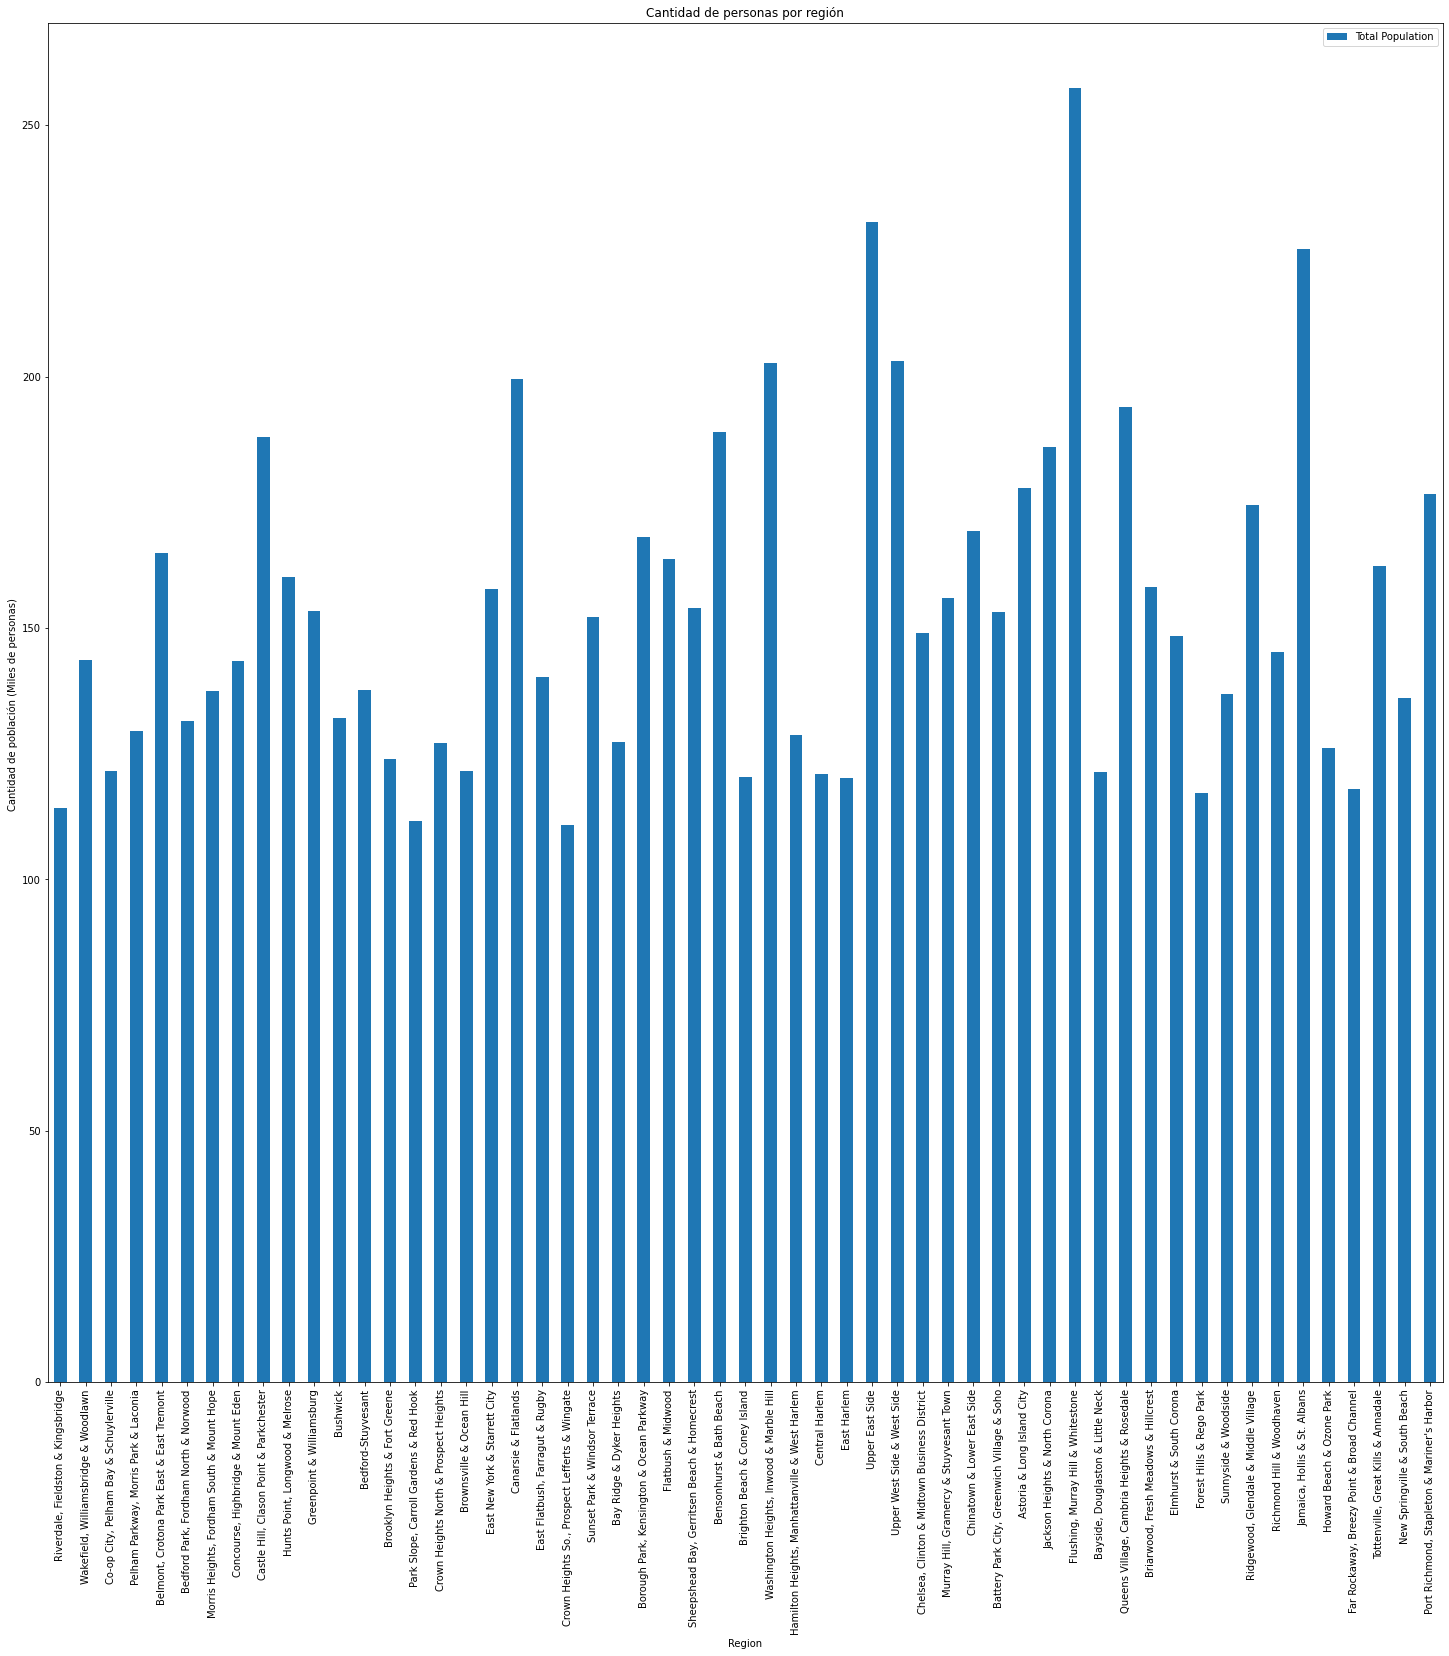

In [0]:

from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn as sns

url = 'https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoodpop.htm'
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

region = soup.find_all('th',class_="left rowheader" )


equipos = list()

for i in region:
  equipos.append(i.text)
  
for i in equipos:
  if(i=="\xa0"):
    equipos.remove(i)
  if (i=="Bronx"):
    equipos.remove(i)
  if (i=="Kings (Brooklyn)"):
    equipos.remove(i)
  if (i=="New York (Manhattan)"):
    equipos.remove(i)
  if (i=="Queens"):
    equipos.remove(i)
  if (i=="Richmond (Staten Island)"):
    equipos.remove(i)

data = soup.find_all('td')


datos = list()
for i in data:
  datos.append(i.text)

df = pd.DataFrame(equipos,columns=["Region"])
datos1= list()
datos2= list()
datos3= list()
cont = 1
for i in datos:
  if(cont==4):
    cont=1
  if(cont == 1):
   datos1.append(i)
  elif cont == 2:
    datos2.append(i)
  else:
    datos3.append(i)
  cont= cont+1
se1 = pd.Series(datos1)
se2 = pd.Series(datos2)
se3 = pd.Series(datos3)

df["Males"] = se1
df["Females"] = se2
df["Total Population"] = se3
df["Total Population"] = df["Total Population"].str.replace(',','.')
df["Total Population"]=pd.to_numeric(df["Total Population"])
print(df["Total Population"].dtype)

ax=df.plot.bar(x = 'Region',y = "Total Population",figsize=(25,25),title="Cantidad de personas por región")
ax.set_ylabel("Cantidad de población (Miles de personas) ")

#df.plot.bar(x="Total Population")

Llamado API

In [0]:
import requests

response = requests.get("https://api.openweathermap.org/data/2.5/weather?lat=44.34&lon=10.99&appid=968b35ff217065d6b61e29e1de4c3bbf")


print(response)